# Загрузка собственного набора изображений в TensorFlow и Keras

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (Файл -> Создать копию на Диске). Свою копию вы сможете изменять и запускать.

Не забудьте подключить GPU для ускорения обучения нейронной сети (Среда Выполнения -> Сменить среду выполнения -> Аппаратный ускоритель -> GPU).

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://www.asozykin.ru/courses/nnpython)".

## Набор данных

В качестве примера собственного набора данных используется [Fruits-360](https://github.com/Horea94/Fruit-Images-Dataset) - набор изображений фруктов.

**Количество классов в наборе данных**: 131.


**Размеры изображений**: 100х100.

**Формат изображений**: jpg.

**Статья с описанием набора данных**: Horea Muresan, Mihai Oltean, [Fruit recognition from images using deep learning](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning), Acta Univ. Sapientiae, Informatica Vol. 10, Issue 1, pp. 26-42, 2018.

In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog
from PIL import Image
%matplotlib inline

## Создаем Tensorflow Dataset'ы

In [13]:
import os
from PIL import Image, ImageOps
from pathlib import Path

# Путь к исходным данным
input_path = Path("C:/myntradataset_test/filtr_image_masterCategory")
# Путь, куда сохраняем обработанные изображения
output_path = Path("C:/myntradataset_test/output_fashion_mnist_style")
output_path.mkdir(parents=True, exist_ok=True)

# Целевой размер
target_size = (60, 80)  # ширина=60, высота=80

def process_image(image_path, save_path):
    # Открываем изображение
    img = Image.open(image_path).convert("L")  # в градации серого
    
    # Инвертируем, чтобы объект был светлый, фон — тёмный
    img = ImageOps.invert(img)
    
    # Масштабируем с сохранением пропорций
    img.thumbnail(target_size, Image.Resampling.LANCZOS)
    
    # Создаём пустое изображение целевого размера (чёрный фон)
    new_img = Image.new("L", target_size, 0)
    # Центрируем
    x_offset = (target_size[0] - img.width) // 2
    y_offset = (target_size[1] - img.height) // 2
    new_img.paste(img, (x_offset, y_offset))
    
    # Сохраняем
    new_img.save(save_path)

# Считаем все изображения для прогресса
all_images = [
    Path(root) / file
    for root, _, files in os.walk(input_path)
    for file in files
    if file.lower().endswith((".png", ".jpg", ".jpeg"))
]
total_images = len(all_images)

# Обрабатываем
for idx, src in enumerate(all_images, start=1):
    # Создаём структуру папок в output
    relative_path = src.relative_to(input_path)
    save_dir = output_path / relative_path.parent
    save_dir.mkdir(parents=True, exist_ok=True)
    
    dst = save_dir / (src.stem + ".png")  # сохраняем в PNG
    
    process_image(src, dst)
    
    # Вывод прогресса
    print(f"[{idx}/{total_images}] Обработано: {src.name}")

print("✅ Обработка завершена.")


[1/44419] Обработано: 10014.jpg
[2/44419] Обработано: 10098.jpg
[3/44419] Обработано: 10099.jpg
[4/44419] Обработано: 10105.jpg
[5/44419] Обработано: 10106.jpg
[6/44419] Обработано: 10107.jpg
[7/44419] Обработано: 10108.jpg
[8/44419] Обработано: 10109.jpg
[9/44419] Обработано: 10130.jpg
[10/44419] Обработано: 10131.jpg
[11/44419] Обработано: 10133.jpg
[12/44419] Обработано: 10134.jpg
[13/44419] Обработано: 10135.jpg
[14/44419] Обработано: 10136.jpg
[15/44419] Обработано: 10137.jpg
[16/44419] Обработано: 10138.jpg
[17/44419] Обработано: 10139.jpg
[18/44419] Обработано: 10140.jpg
[19/44419] Обработано: 10141.jpg
[20/44419] Обработано: 10164.jpg
[21/44419] Обработано: 10181.jpg
[22/44419] Обработано: 10192.jpg
[23/44419] Обработано: 10193.jpg
[24/44419] Обработано: 10194.jpg
[25/44419] Обработано: 10195.jpg
[26/44419] Обработано: 10196.jpg
[27/44419] Обработано: 10197.jpg
[28/44419] Обработано: 10198.jpg
[29/44419] Обработано: 10199.jpg
[30/44419] Обработано: 10200.jpg
[31/44419] Обработа

In [2]:
batch_size=256
image_size=(60, 80)

In [14]:
# Параметры
data_dir = 'C:/myntradataset_test/output_fashion_mnist_style'
image_size = (60, 80)  # Укажите ваш размер
batch_size = 128          # Укажите ваш batch size

# Желаемое разделение (можно менять)
train_split = 0.7
val_split = 0.3

# Проверка корректности разделения
assert abs(train_split + val_split - 1.0) < 0.001, "Сумма долей должна быть равна 1"

# Создаем полный датасет С ПЕРЕМЕШИВАНИЕМ
full_dataset = image_dataset_from_directory(
    data_dir,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,  # 🔥 Включено перемешивание!
    seed=42,       # Для воспроизводимости
)

# Сохраняем имена классов
class_names = full_dataset.class_names
print("Найдены классы:", class_names)

# Подсчет общего количества батчей
total_batches = len(full_dataset)
print(f"Всего батчей: {total_batches}")

# Разделяем датасет
train_size = int(train_split * total_batches)
val_dataset = full_dataset.skip(train_size)
train_dataset = full_dataset.take(train_size)

# Проверяем размеры
print(f"\nРазмеры после разделения:")
print(f"Обучающая выборка: {len(train_dataset)} батчей (~{train_split*100:.0f}%)")
print(f"Валидационная выборка: {len(val_dataset)} батчей (~{val_split*100:.0f}%)")

# Проверка распределения классов
def check_class_distribution(dataset, name):
    class_counts = {class_name: 0 for class_name in class_names}
    for images, labels in dataset:  # Убрали .unbatch()
        labels_np = labels.numpy()  # Получаем numpy массив меток для батча
        for label in labels_np:     # Итерируемся по массиву меток
            class_counts[class_names[label]] += 1
    print(f"\nРаспределение классов в {name}:")
    total = sum(class_counts.values())
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} примеров ({(count/total)*100:.1f}%)")

check_class_distribution(train_dataset, "обучающей выборке")
check_class_distribution(val_dataset, "валидационной выборке")

# Оптимизация производительности
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

print("\n✅ Разделение завершено успешно! Данные перемешаны и распределены равномерно.")

Found 44419 files belonging to 7 classes.
Найдены классы: ['Accessories', 'Apparel', 'Footwear', 'Free Items', 'Home', 'Personal Care', 'Sporting Goods']
Всего батчей: 348

Размеры после разделения:
Обучающая выборка: 243 батчей (~70%)
Валидационная выборка: 105 батчей (~30%)

Распределение классов в обучающей выборке:
Accessories: 7847 примеров (25.2%)
Apparel: 14965 примеров (48.1%)
Footwear: 6500 примеров (20.9%)
Free Items: 73 примеров (0.2%)
Home: 1 примеров (0.0%)
Personal Care: 1704 примеров (5.5%)
Sporting Goods: 14 примеров (0.0%)

Распределение классов в валидационной выборке:
Accessories: 3421 примеров (25.7%)
Apparel: 6447 примеров (48.4%)
Footwear: 2714 примеров (20.4%)
Free Items: 31 примеров (0.2%)
Home: 0 примеров (0.0%)
Personal Care: 692 примеров (5.2%)
Sporting Goods: 10 примеров (0.1%)

✅ Разделение завершено успешно! Данные перемешаны и распределены равномерно.


In [15]:
# Присваиваем атрибут каждому датасету
train_dataset.class_names = class_names
val_dataset.class_names = class_names

**Примеры изображений**

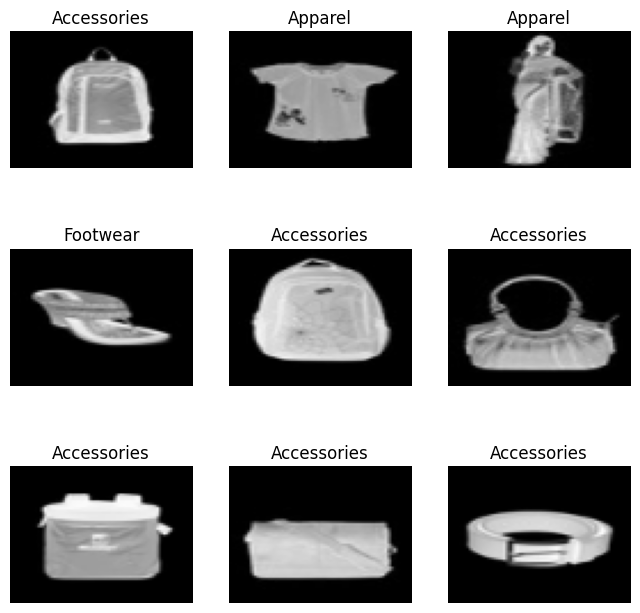

In [16]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Набор данных для тестирования**

In [7]:
test_dataset = image_dataset_from_directory('C:/myntradataset_test/test',
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 3 files belonging to 2 classes.


In [8]:
test_dataset.class_names = class_names 
test_dataset.class_names

['Accessories',
 'Apparel',
 'Footwear',
 'Free Items',
 'Home',
 'Personal Care',
 'Sporting Goods']

## Создаем нейронную сеть

In [20]:
# Создаем последовательную модель
model = Sequential()
# Сверточный слой
model.add(Conv2D(16, (5, 5), padding='same',
                 input_shape=(60, 80, 3), activation='relu'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Полносвязная часть нейронной сети для классификации
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
# Выходной слой, 131 нейрон по количеству классов
model.add(Dense(7, activation='softmax'))

c:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Компилируем модель**

In [21]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [22]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=3,
                    verbose=1)

Epoch 1/3
243/243 ━━━━━━━━━━━━━━━━━━━━ 121s 477ms/step - accuracy: 0.8978 - loss: 0.6195 - val_accuracy: 0.9690 - val_loss: 0.1222
Epoch 2/3
243/243 ━━━━━━━━━━━━━━━━━━━━ 93s 382ms/step - accuracy: 0.9737 - loss: 0.1025 - val_accuracy: 0.9724 - val_loss: 0.0968
Epoch 3/3
243/243 ━━━━━━━━━━━━━━━━━━━━ 89s 367ms/step - accuracy: 0.9809 - loss: 0.0764 - val_accuracy: 0.9738 - val_loss: 0.0952


## Оцениваем качетсво обучения сети

In [12]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.3333 - loss: 1.4899


In [13]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 33.3333


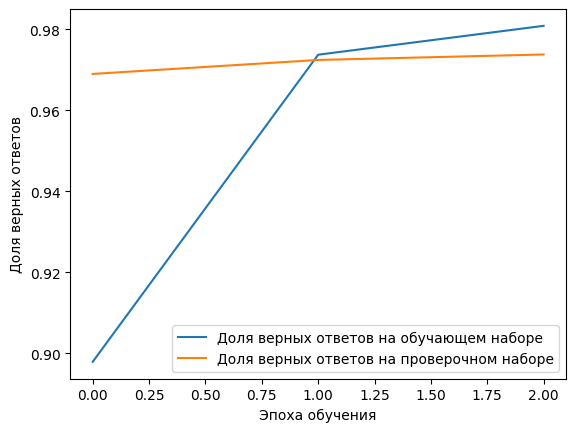

In [23]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

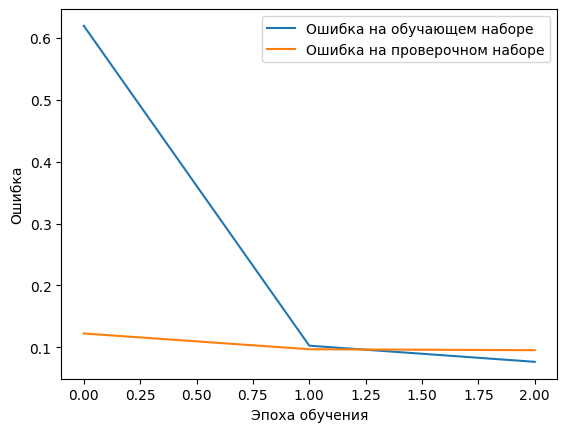

In [28]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Сохраняем обученную нейронную сеть

In [27]:
model.save("models_new.keras")

Загрузка своего фото

In [ ]:
import numpy as np
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image
from rembg import remove
from tensorflow.keras.models import load_model

model = load_model("C:/myntradataset_test/model_new.h5")

# Предобработка с сегментацией
def preprocess_image_with_segmentation(img_path, target_size=(60, 80)):
    # Читаем изображение и удаляем фон
    img = Image.open(img_path).convert("RGBA")
    img_no_bg = remove(img)  # Удаление фона
    
    # Преобразуем в градации серого (фон станет чёрным)
    background = Image.new("RGBA", img_no_bg.size, (0, 0, 0, 255))
    img_combined = Image.alpha_composite(background, img_no_bg).convert("L")
    
    # Инвертируем цвета
    img_inverted = ImageOps.invert(img_combined)
    
    # Масштабируем с сохранением пропорций
    img_inverted.thumbnail(target_size, Image.Resampling.LANCZOS)
    
    # Создаём пустое изображение целевого размера
    new_img = Image.new("L", target_size, 0)
    
    # Центрируем
    x_offset = (target_size[0] - img_inverted.width) // 2
    y_offset = (target_size[1] - img_inverted.height) // 2
    new_img.paste(img_inverted, (x_offset, y_offset))
    
    return new_img

# Функция для предсказания
def predict_image(img_path):
    processed_img = preprocess_image_with_segmentation(img_path, target_size=(60, 80))
    img_array = image.img_to_array(processed_img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred = model.predict(img_array)
    class_idx = np.argmax(pred[0])
    return class_names[class_idx]

# Пример
image_path = "C:/myntradataset_test/test/Apparel/1.jpg"
print(f"Предсказанный класс: {predict_image(image_path)}")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:\myntradataset_test\model_new.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [12]:
import numpy as np
from PIL import Image


# 3. Функция для предсказания
def predict_image(img_path):
    img = Image.open(img_path).resize((80, 60))  # width, height (как у тебя в обучении)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred = model.predict(img_array)
    class_idx = np.argmax(pred[0])
    return class_names[class_idx]

# 4. Пример использования (укажи свой путь к изображению)
image_path = "C:/myntradataset_test/test/Accessories/unnamed.jpg"
print(f"Предсказанный класс: {predict_image(image_path)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Предсказанный класс: Apparel
